# Baseline model: 50 - 50 Dummy Random Guessing Classifier

Import packages

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

Prepare for preprocessing and Feature Engineering

In [2]:
# Automatically add the project root (1 level up) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import preprocessor, VandalismScorer

Read in the train data and preprocess it

In [3]:
df_train = pd.read_csv(project_root+"/data/train.csv")
preprocessor(df_train)

Raw features including add_lines and deleted_lines

In [4]:
feature_cols = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "EditID",
    "added_lines",
    "deleted_lines"
]

Initialize the cross-validation

In [5]:
num_splits = 5
num_models = 4
kfold = StratifiedKFold(num_splits, random_state=42, shuffle=True)

In [6]:
accs_dummy, f1s_dummy, prec_dummy, recall_dummy = [], [], [], []

for fold, (train_index, test_index) in enumerate(kfold.split(df_train[feature_cols], df_train.isvandalism)):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]

    X_ho = df_ho[feature_cols]
    y_ho = df_ho['isvandalism']

    dummy_pipe = Pipeline([
        ('scorer', VandalismScorer(n_splits=4)),
        ('dummy', DummyClassifier(strategy="uniform", random_state=fold))
    ])
    dummy_pipe.fit(X_ho, y_ho)  # Training is a formality: it does not use data
    dummy_pred = dummy_pipe.predict(X_ho)
    acc = accuracy_score(y_ho, dummy_pred)
    f1 = f1_score(y_ho, dummy_pred)
    accs_dummy.append(acc)
    f1s_dummy.append(f1)
    prec = precision_score(y_ho, dummy_pred)
    recall = recall_score(y_ho, dummy_pred)
    prec_dummy.append(prec)
    recall_dummy.append(recall) 

In [9]:
print(f"\nDummy (random guessing) average accuracy={sum(accs_dummy)/len(accs_dummy):.4f}, average F1={sum(f1s_dummy)/len(f1s_dummy):.4f}, average precision={sum(prec_dummy)/len(prec_dummy):.4f}, average recall={sum(recall_dummy)/len(recall_dummy):.4f}")


Dummy (random guessing) average accuracy=0.4982, average F1=0.4915, average precision=0.4850, average recall=0.4982


# Dummy baseline on testing set

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#import and preprocess test data
test_df = pd.read_csv("../Data/test.csv")
preprocessor(test_df)

In [9]:
#make prediction
y_pred = dummy_pipe.predict(test_df[feature_cols])


Classification Report:
              precision    recall  f1-score   support

       False     0.5132    0.4995    0.5063      3259
        True     0.4876    0.5013    0.4943      3096

    accuracy                         0.5004      6355
   macro avg     0.5004    0.5004    0.5003      6355
weighted avg     0.5007    0.5004    0.5005      6355

0.5003933910306845
0.4943462334766683


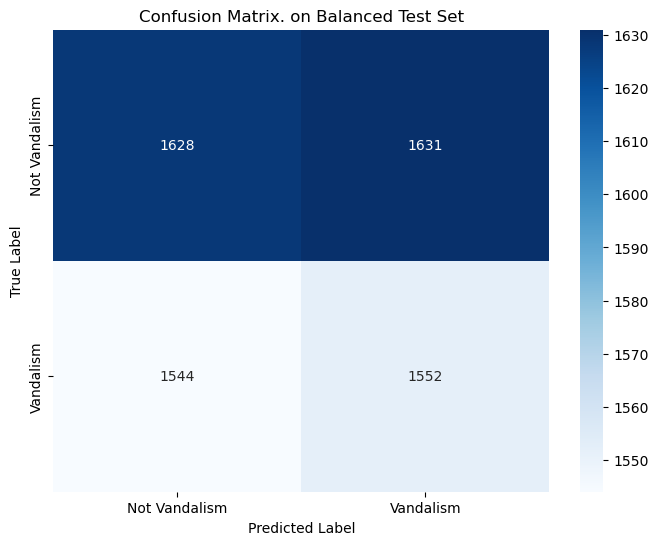

In [10]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_df.isvandalism, y_pred, digits=4))
print(accuracy_score(test_df.isvandalism, y_pred))
print(f1_score(test_df.isvandalism, y_pred))

#heatmap
confmat = confusion_matrix(test_df.isvandalism,y_pred)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix. on Balanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Balanaced Confusion Matrix') #uncomment to save
plt.show()

## Imbalanced Test set

In [11]:
testimba_df =  pd.read_csv("../Data/test_imbalanced.csv")
preprocessor(testimba_df)


Classification Report:
              precision    recall  f1-score   support

       False     0.9031    0.4864    0.6323       479
        True     0.0855    0.4792    0.1451        48

    accuracy                         0.4858       527
   macro avg     0.4943    0.4828    0.3887       527
weighted avg     0.8286    0.4858    0.5879       527

0.4857685009487666
0.14511041009463724


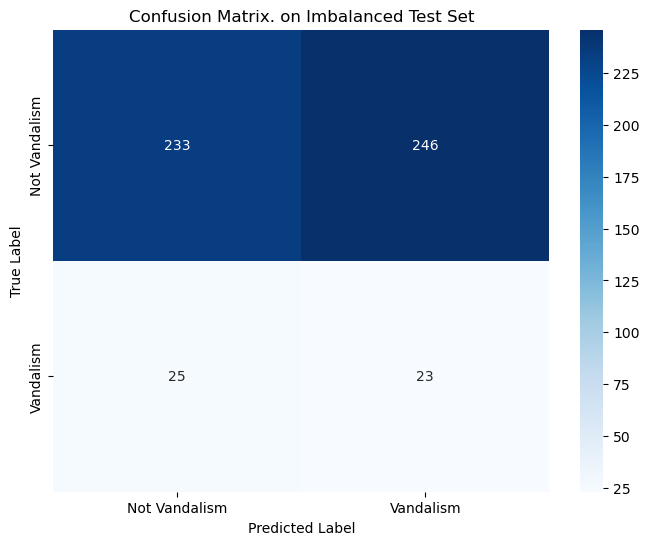

In [13]:
y_predimba = dummy_pipe.predict(testimba_df)

# Classification Report
print("\nClassification Report:")
print(classification_report(testimba_df.isvandalism, y_predimba, digits=4))
print(accuracy_score(testimba_df.isvandalism, y_predimba))
print(f1_score(testimba_df.isvandalism, y_predimba))

#heatmap
confmat = confusion_matrix(testimba_df.isvandalism,y_predimba)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix. on Imbalanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Imbalanaced Confusion Matrix') #uncomment to save
plt.show()